In [449]:
import argparse
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm

import jax
from jax.experimental.ode import build_odeint
import jax.numpy as np
from jax.random import PRNGKey
from jax import lax

import numpyro
import numpyro.distributions as dist
from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

## Deterministic model

In [417]:
def dx_dt(x, t, beta, gamma):
    """
    SIR equations. Real positive parameters `beta`, `gamma`,
    describe the infection rate and recovery rate.
    Also tracks new infections.
    """
    S = x[0]
    I = x[1]
    R = x[2]
    n = S + I + R
    I_tot = x[3]
    dS_dt = - beta * S * I / n
    dI_dt = beta * S * I / n - gamma * I
    dR_dt = gamma * I
    dItot_dt = beta * S * I / n
    return np.stack([dS_dt, dI_dt, dR_dt, dItot_dt])

SIR_int = build_odeint(dx_dt, rtol=1e-5, atol=1e-3, mxstep=500)

def SIR_deterministic(ts, beta=2.5/14, gamma=1.0/14, N=1e4, I_frac=0.01):
    x_init = N*np.array([1-I_frac, I_frac, 0, 0])
    theta = np.array([beta, gamma])
    return SIR_int(x_init, ts, *theta)

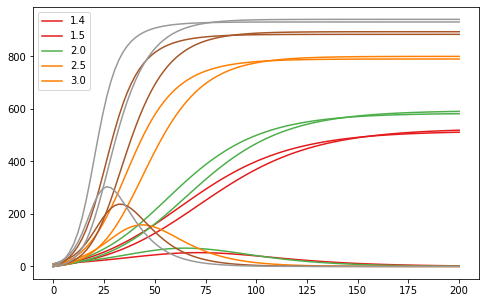

In [418]:
# run the deterministic model
ts = np.linspace(0.0, 200.0, 100)
gamma = 1/10

R0_vals = [1.4, 1.5, 2.0, 2.5, 3.0]

n = len(R0_vals)
color=iter(cm.Set1(np.linspace(0,1,n)))

plt.figure(figsize=(8,5))
for R0 in R0_vals:
    beta = R0*gamma
    c = next(color)
    x = SIR_deterministic(ts, beta, gamma, N=1e3)
    plt.plot(ts, x[:,1:], color=c)

plt.legend(plt.gca().lines[::2], R0_vals)
plt.show()

## Current model: SIR model for new cases with random parameters/observations, deterministic dynamics

This model introduces a new state variable $C(t)$ to track the cumulative number of people infected between time $0$ and time $t$. 

$$
\begin{aligned}
\frac{dS}{dt} &= - \beta S I /n  \\
\frac{dI}{dt} &= \beta S I / n - \gamma I \\
\frac{dR}{dt} &= \gamma I  \\
\frac{dC}{dt} &= \beta S I /n
\end{aligned}
$$

The observation $y_k$ is the number of new cases reported on day $k$. The actual number of new cases on day $k$ is $C(k) - C(k-1)$. The observation is modeled as:
$$
y_k \sim \text{Normal}\Big(p \cdot \big(C(k) - C(k-1)\big), \sigma\Big)
$$
Here $p$ is a detection rate, and $\sigma$ is the the observation variance. Other models (Binomial, etc.) are possible but haven't worked as well numerically.

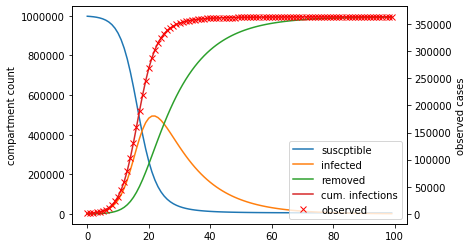

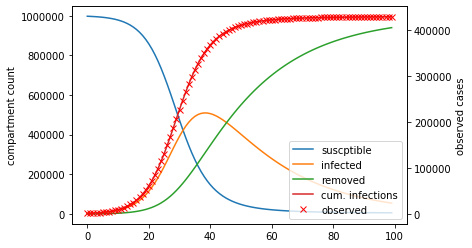

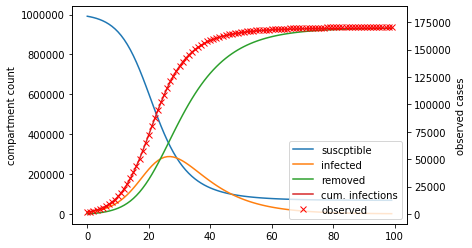

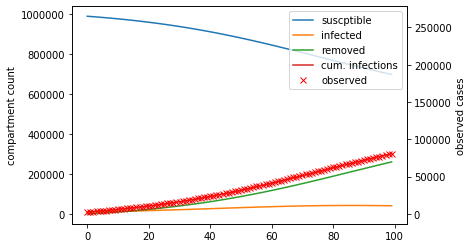

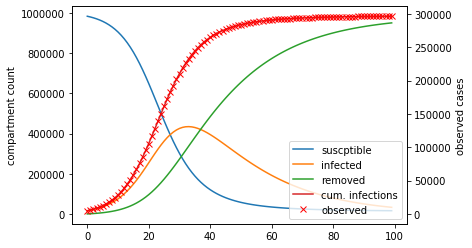

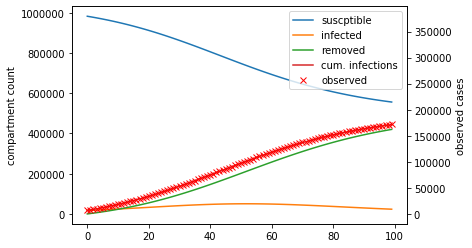

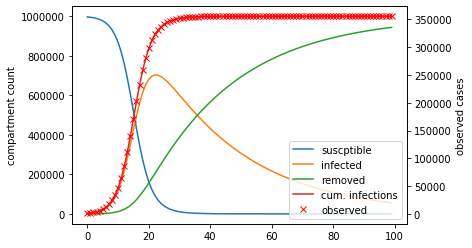

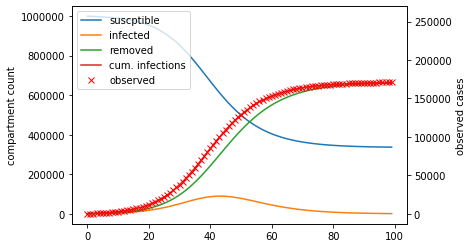

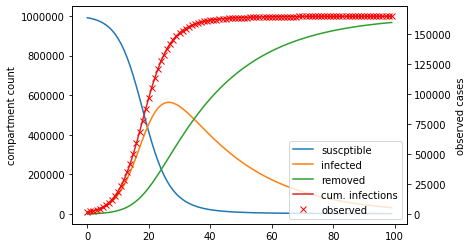

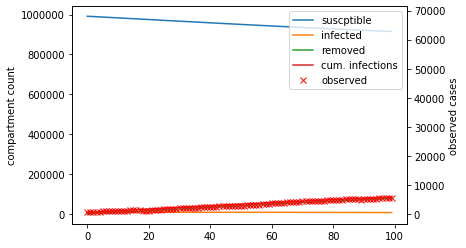

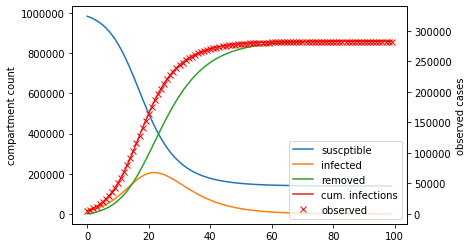

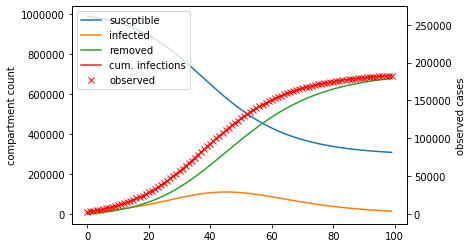

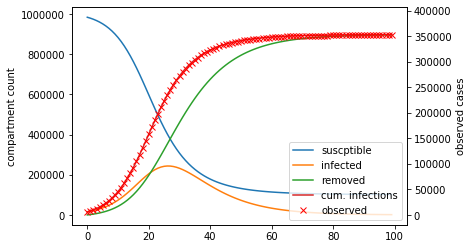

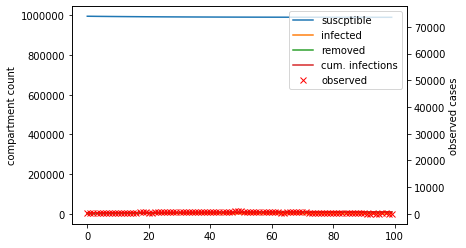

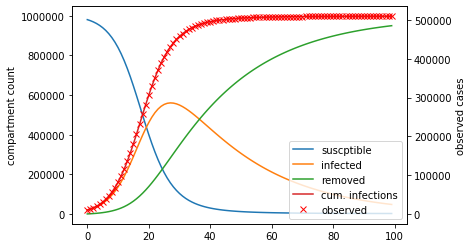

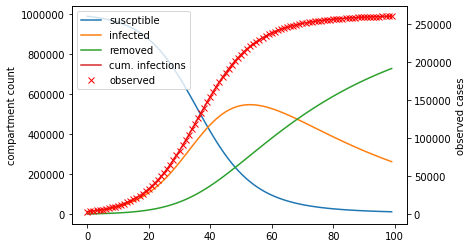

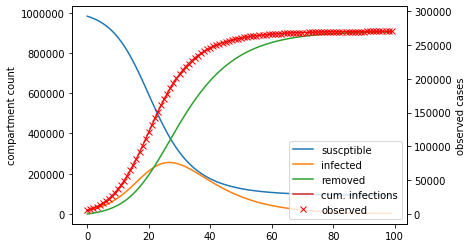

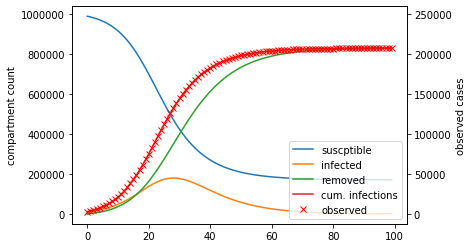

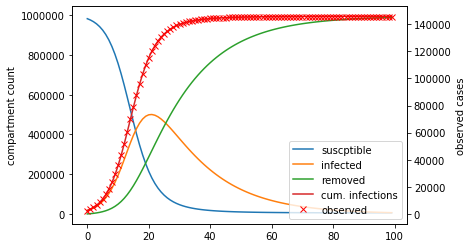

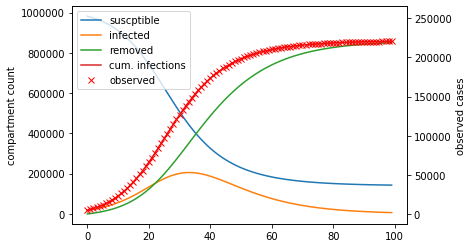

In [494]:
def SIR_hybrid(T=50, 
               N=1e5, 
               dt=1.0, 
               duration_mean=10,
               duration_scale_factor=0.5,
               R0_mean=2.2,
               R0_scale_factor=0.5,
               obs_factor=100,
               new_cases=None):

    I_init = numpyro.sample("I_init", dist.Uniform(0, 0.02))
    
    x_init = N*np.array([1-I_init, I_init, 0.0, I_init])

    shape = 5
    gamma = numpyro.sample("gamma", dist.Gamma(shape, shape*duration_mean))
    beta = numpyro.sample("beta", dist.Gamma(shape, shape*duration_mean/R0_mean))

    obs_rate = numpyro.sample("obs_rate", dist.Beta(3, 7))
    
    ts = np.arange(0, T, dt)
    x = SIR_int(x_init, ts, beta, gamma)
    numpyro.deterministic("x", x)
        
    new_infections = np.diff(np.hstack((0, x[:,3])))

    obs_model = 'normal'
    
    if obs_model == 'beta':
        if new_cases is None:
            obs = None
        else:
            print("evidence")
            obs = new_cases / new_infections
    
        conc = new_infections / N * obs_factor
        #conc = obs_factor

        obs_frac = numpyro.sample(
                'obs_frac',
                dist.Beta(obs_rate * conc, (1-obs_rate) * conc),
                #sample_shape=(T,),
                obs = obs)

        y = new_infections * obs_frac

        numpyro.deterministic("y", y)
        
    elif obs_model == 'binomial':
        y = numpyro.sample("y", dist.Binomial(new_infections, obs_rate), obs=new_cases)
        
    elif obs_model == 'normal':
        obs_noise = 50
        y = numpyro.sample("y", dist.Normal(new_infections * obs_rate, obs_noise), obs=new_cases)
    
    else:
        raise ValueError('bad obs model')
        
    return x, y, obs_rate

def test_hybrid(i, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        x, y, obs_rate = SIR_hybrid(**kwargs)

    T = len(y)
    ts = np.arange(T)
    
    y_cum = np.cumsum(y)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x)
    
    l2 = ax2.plot(ts, y_cum, 'x', color='r')
    
    plt.legend(l1 + l2, ['suscptible', 'infected', 'removed', 'cum. infections', 'observed'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim( obs_rate * ylim )
    
    plt.show()

for i in range(20):
    test_hybrid(i, T=100, N=1e6, obs_factor=10)

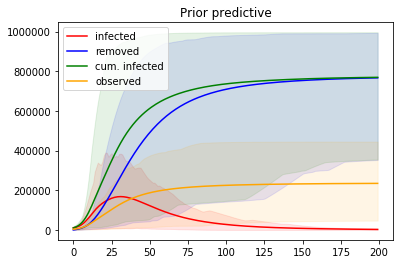

In [495]:
def plot_samples(samples, legend=True):
    
    T = samples['x'].shape[1]
    ts = np.arange(T)
    
    mean_x = samples['x'].mean(axis=0)
    pi_x = np.percentile(samples['x'], (10, 90), axis=0)
    
    #plt.plot(ts, mean[:,1], color='g')
    plt.plot(ts, mean_x[:,1], color='r')
    plt.plot(ts, mean_x[:,2], color='b')
    plt.plot(ts, mean_x[:,3], color='g')
    
    #plt.fill_between(ts, pi[0, :, 0], pi[1, :, 0], color="g", alpha=0.1)
    plt.fill_between(ts, pi_x[0, :, 1], pi_x[1, :, 1], color="r", alpha=0.1)
    plt.fill_between(ts, pi_x[0, :, 2], pi_x[1, :, 2], color="b", alpha=0.1)
    plt.fill_between(ts, pi_x[0, :, 3], pi_x[1, :, 3], color="g", alpha=0.1)

    labels = ['infected', 'removed', 'cum. infected']
    
    if 'y' in samples:
        y_cum = np.nancumsum(samples['y'], axis=1)
        mean_y = np.nanmean(y_cum,axis=0)
        plt.plot(ts, mean_y, color='orange')
        pi_y = np.percentile(y_cum, (10, 90), axis=0)    
        plt.fill_between(ts, pi_y[0, :], pi_y[1, :], color="orange", alpha=0.1)
        labels.append('observed')
    
    if legend:
        plt.legend(labels)

    return labels
    

T = 200
N = 1e6
predictive = Predictive(SIR_hybrid, 
                        posterior_samples = {}, 
                        num_samples=100)

samples = predictive(PRNGKey(2), T=T, N=N)

plot_samples(samples)

plt.title('Prior predictive')
plt.show()

In [379]:
def load_us():
    df = pd.read_csv('us-daily.csv')
    df.date = pd.to_datetime(df.date, format='%Y%m%d')
    df = df.set_index('date')
    df = df.sort_index()
    return df.positive

def load_state(state='MA'):
    df = pd.read_csv('states-daily.csv')
    df.date = pd.to_datetime(df.date, format='%Y%m%d')
    df = df.set_index('date')
    df = df.sort_index()
    return df[df.state==state].positive.sort_index()

In [496]:
#positive = load_state('MA')
positive = load_us()
new_cases = np.array(np.diff(positive))

kernel = NUTS(SIR_hybrid)
mcmc = MCMC(kernel, num_warmup=5000, num_samples=5000, num_chains=1)

T = len(positive)
init = {
    'I_init': 0.01,
    'gamma': 1/10.0,
    'beta': 2.5/10.0,
    'obs_rate' : 0.3
}

mcmc.run(jax.random.PRNGKey(2), N=1e6, T=T, new_cases=new_cases, init_params=init)
mcmc.print_summary()
mcmc_samples = mcmc.get_samples()

sample: 100%|██████████| 10000/10000 [01:54<00:00, 87.70it/s, 63 steps of size 6.15e-03. acc. prob=0.95]   



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    I_init      0.00      0.00      0.00      0.00      0.00   1021.07      1.00
      beta      0.48      0.05      0.47      0.40      0.55   1086.06      1.00
     gamma      0.17      0.05      0.17      0.10      0.25   1055.14      1.00
  obs_rate      0.45      0.11      0.44      0.27      0.61   1071.35      1.00

Number of divergences: 0


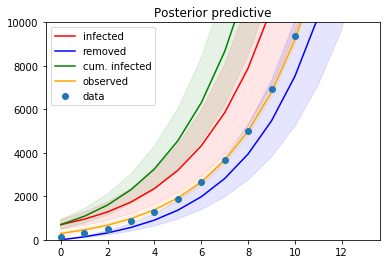

In [497]:
# Visualize posterior predictive samples
T = len(new_cases)
N = 1e6
post_pred = Predictive(SIR_hybrid, posterior_samples = mcmc_samples)

post_pred_samples = post_pred(PRNGKey(2), T=T, N=N)

labels = plot_samples(post_pred_samples)
plt.title('Posterior predictive')
plt.plot(np.cumsum(new_cases), 'o')
plt.legend(labels + ['data'])
plt.ylim([0, 10000])
plt.show()

growth_rate = np.mean(mcmc_samples['beta']/mcmc_samples['beta'])

R_0_est = np.mean(mcmc_samples['beta']/mcmc_samples['beta'])

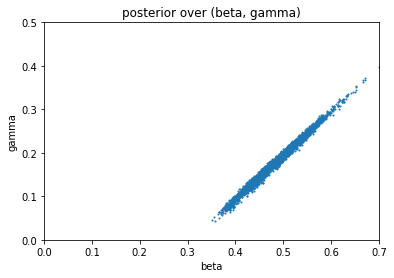

R0:  2.9040284


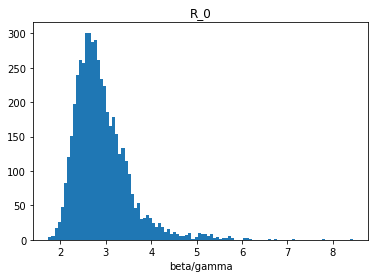

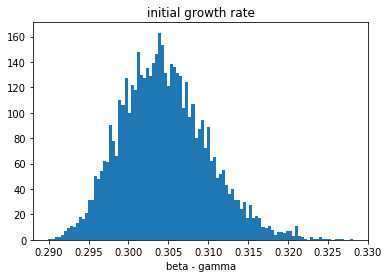

In [502]:
beta = mcmc_samples['beta']
gamma = mcmc_samples['gamma']
plt.scatter(beta, gamma, s=1)
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.xlim([0, 0.7])
plt.ylim([0, 0.5])
plt.show()

plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0: ", R_0_mean)
plt.show()

growth_rate = mcmc_samples['beta'] - mcmc_samples['gamma']
plt.hist(growth_rate, bins=100)
plt.title('initial growth rate')
plt.xlabel('beta - gamma')
plt.show()


LinregressResult(slope=0.8835929018734573, intercept=0.1650638991844859, rvalue=0.6249909364269993, pvalue=0.0, stderr=0.015610856331426738)


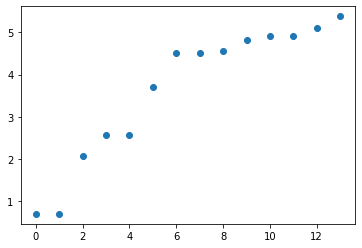

In [489]:
import scipy.stats
model = scipy.stats.linregress(gamma, beta)
print(model)

t = np.arange(T)
logy = np.log(np.array(positive))
plt.plot(t, logy, 'o')


## Old: stochastic dynamics

In [4]:
def SIR_stochastic(dt = 1.0, 
                   steps = 50,
                   N = 1e5,
                   I_frac=0.05,
                   duration_mean=10,
                   duration_scale_factor=0.5,
                   R0_mean=2.2,
                   R0_scale_factor=0.2,
                   obs_rate=0.3,
                   obs_conc=50,
                   SI_conc=50,
                   IR_conc=50,
                   dynamics="Beta"):
    
    x_init = N*np.array([1-I_frac, I_frac, 0])
    N = x_init.sum()
    
    duration = numpyro.sample(
        "duration", 
        dist.TruncatedNormal(low=0.,
                             loc=duration_mean, 
                             scale=duration_mean*duration_scale_factor))
    
    R0 = numpyro.sample("R0",
                        dist.TruncatedNormal(low=0.,
                                             loc=R0_mean,
                                             scale=R0_scale_factor))
    
    gamma = 1./duration    
    beta = R0 * gamma
    
    numpyro.deterministic("beta", beta)
    numpyro.deterministic("gamma", gamma)
        
    j = 0
    def advance(x, ignore):
        nonlocal j

        S, I, R = x
        
        rate_SI = beta * I / N
        rate_IR = gamma

        p_SI = 1 - np.exp(-rate_SI * dt)
        p_IR = 1 - np.exp(-rate_IR * dt)
                

        if dynamics=="Binomial":
            n_SI = numpyro.sample(f'n_SI_{j}', dist.Binomial(S, p_SI))
            n_IR = numpyro.sample(f'n_IR_{j}', dist.Binomial(I, p_IR))
        
        elif dynamics=="Beta":
            n_SI = S * numpyro.sample(f'n_SI_{j}', dist.Beta(p_SI * SI_conc, 
                                                             (1-p_SI) * SI_conc))
            n_IR = I * numpyro.sample(f'n_IR_{j}', dist.Beta(p_IR * SI_conc, 
                                                             (1-p_IR) * IR_conc))

        elif dynamics=="Poisson":
            n_SI = numpyro.sample(f'n_SI_{j}', dist.Poisson(S * rate_SI * dt))
            n_IR = numpyro.sample(f'n_IR_{j}', dist.Poisson(I * rate_IR * dt))
            
        else:
            raise ValueError("Bad dynamics")
        
        j = j + 1
        
        delta = np.array([n_SI, n_IR])
        flow = np.array([-n_SI, n_SI - n_IR, n_IR])
        x_new = x + flow

        return x_new, (x_new, delta)

    _, STATE = lax.scan(advance, x_init, None, steps)
    X, delta = STATE
    
    X = np.vstack([x_init, X])
    
    n_SI = delta[:,0]
    numpyro.deterministic("X", X)
    
    y = n_SI * numpyro.sample('obs_frac', 
                              dist.Beta(obs_rate*obs_conc,
                                        (1-obs_rate)*obs_conc),
                              sample_shape=(steps,))
    
    numpyro.deterministic("y", y)

    return X, y

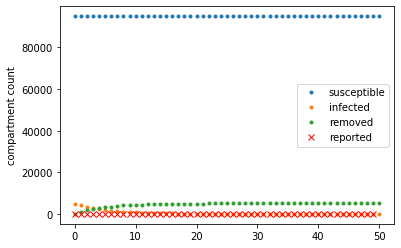

In [6]:
with numpyro.handlers.seed(rng_seed=6):
    X, y = SIR_stochastic(dt=1.0, steps=50, N=1e5)

y = np.cumsum(y)
fig, ax1 = plt.subplots(figsize=(6,4))

l1 = ax1.plot(X, '.')
ax1.set_ylabel('compartment count')

plotyy = False
if plotyy:
    ax2 = ax1.twinx()
    l2 = ax2.plot(y, 'x', color='r')    
    ax2.set_ylabel('confirmed cases', color='r')
    ax2.spines['right'].set_color('r')
    ax2.yaxis.label.set_color('r')
    ax2.tick_params(axis='y', colors='r')
else:
    l2 = ax1.plot(y, 'x', color='r')

plt.legend(l1 + l2, ['susceptible', 'infected', 'removed', 'reported'])

plt.show()